# model 3-3: 過去の点$x$を参照にして次の点を選択する場合

In [1]:
%matplotlib inline
import numpy as np
from scipy.spatial.distance import euclidean as euc
import matplotlib.pyplot as plt
import mpld3
from mpld3 import plugins
from mpld3.utils import get_id


class Person:

    def __init__(self, S, a, p=0.5):
        self.S = S
        self.a = a
        self.p = p

    def gather(self):
        """make person to participate the meeting.
        """
        self.ideas = self.has_idea()

    def has_idea(self):
        """a person has self.S ideas with self.a dimension.
        """
        return list(np.random.rand(self.S, self.a))

    def chose_idea(self, idea, idea2=None):

        def nearness1(x, y, z):
            """calculate nearness of x for (y, z)
            by calculating a linear combination.
            """
            alpha = 1.
            beta = 1.
            return alpha*euc(x, y) + beta*euc(x, z)
        
        def nearness2(x, y, z):
            """calculate nearness of x for (y, z)
            by distance between x and the dividing point of (y, z) with t.
            """
            # t > 0
            # t <= 1: interior division
            # t > 1: exterior division
            t = 0.5 
            x, y, z = np.array(x), np.array(y), np.array(z)
            return euc(t*(y-x) + (1.-t)*(z-x), (0., 0.))
        
        if len(self.ideas) == 0:
            return False
        # return min(d) and its idea_id
        if idea2 == None:
            return min([(euc(vec, idea), idea_id) for idea_id, vec in enumerate(self.ideas)])
        else:
            return min([(nearness1(vec, idea, idea2), idea_id)
                        for idea_id, vec in enumerate(self.ideas)])

class Meeting:

    """Simulate a meeting with "simple3" situation.

    Give keyword arguments:

        K = 20 # Time limit
        N = 6 # a number of participants
        S = 10 # a number of ideas for each participants
        a = 2 # the dimension of an idea
        p = 0.5 # probability that a person speak
        draw = True # draw image or don't

    Output:

        self.minutes: list of
                      ( idea(which is vector with a dimension)
                      , who(person_id in the list "self.membes"))
        self.k: stopped time (=len(self.minutes))
    """

    def __init__(self, K=20, N=6, S=10, a=2, p=0.5, draw=True, case=2):
        self.K = K
        self.N = N
        self.S = S
        self.a = a
        self.p = p
        self.draw = draw
        self.case = case  # case in the above cell: 2, 3, 4 or 5
        if not self.case in [2, 3, 4, 5]:
            raise ValueError
        self.members = []
        self.minutes = []  # list of (idea, who)
        self.k = 0

    def gather_people(self):
        """gather people for the meeting.

        You can edit what ideas they have in here.
        """
        for n in range(self.N):
            person = Person(self.S, self.a, self.p)
            # person.has_idea = some_function()
            # some_function: return list of self.S arrays with dim self.a.
            person.gather()
            self.members.append(person)
        self.members = np.array(self.members)

    def progress(self):
        """meeting progress
        """
        self.init()
        preidea = self.subject
        prepreidea = None
        self.k = 1
            
        while self.k < self.K + 1:
            # l: (distance, speaker, idea_id) list for who can speak
            l = []
            for person_id, person in enumerate(self.members):
                # chosed: (distance, idea_id)
                chosed = person.chose_idea(preidea, prepreidea)
                if chosed:
                    l.append((chosed[0], person_id, chosed[1]))
            # if no one can speak: meeting ends.
            if len(l) == 0:
                print "no one can speak."
                break
            i = np.array([(person_id, idea_id)
                 for distance, person_id, idea_id in sorted(l)])

            for person_id, idea_id in i:
                rn = np.random.rand()
                if rn < self.members[person_id].p:
                    idea = self.members[person_id].ideas.pop(idea_id)
                    self.minutes.append((idea, person_id))
                    if self.case == 3:
                        preidea = idea
                    elif self.case == 4:
                        prepreidea = idea
                    elif self.case == 5:
                        prepreidea = preidea
                        preidea = idea
                    self.callback()
                    self.k += 1
                    break
            else:
                self.minutes.append((self.subject, self.N))
                self.callback()
                self.k += 1

        self.after()

    def init(self):
        self.gather_people()
        self.subject = np.random.rand(self.a)
        self.minutes.append((self.subject, self.N))
        if self.draw:
            self.fig = plt.figure(figsize=(9, 9))
            self.ax = self.fig.add_subplot(1, 1, 1)
            self.labels = ['subject']
            self.s1 = [self.ax.scatter(self.subject[0], self.subject[1],
                                       c=next(self.ax._get_lines.color_cycle))]
            self.ax.text(
                self.subject[0], self.subject[1], '0', fontsize=5)
            for i, member in enumerate(self.members):
                x = [vec[0] for vec in member.ideas]
                y = [vec[1] for vec in member.ideas]
                s = self.ax.scatter(
                    x, y, c=next(self.ax._get_lines.color_cycle), alpha=0.2)
                self.labels.append(str(i))
                self.s1.append(s)

    def callback(self):
        if self.draw:
            if self.minutes[-1][1] == self.N or self.minutes[-2][1] == self.N:
                alpha = 0.2
            else:
                alpha = 1.0
            ix = self.minutes[-2][0][0]
            iy = self.minutes[-2][0][1]
            jx = self.minutes[-1][0][0]
            jy = self.minutes[-1][0][1]
            l1 = self.ax.plot([ix, jx], [iy, jy], color='black', alpha=alpha)
            self.ax.text(jx, jy, '%d' % self.k, color='blue', fontsize=12)
        else:
            pass

    def after(self):
        self.minutes = np.array(self.minutes)
        if self.draw:
            plugins.connect(
                self.fig, plugins.InteractiveLegendPlugin(
                    self.s1, self.labels, ax=self.ax))
            mpld3.enable_notebook()
        else:
            pass

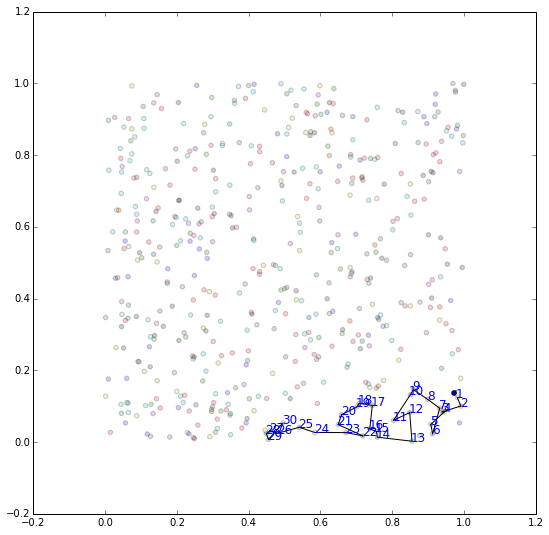

In [2]:
meeting = Meeting(K=30, N=10, S=50, a=2, p=0.6, case=3)
meeting.progress()